# Dependencies

### Global Dependencies

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torchvision.models.feature_extraction import create_feature_extractor

from torchsummary import summary

from torchmetrics import Accuracy, ConfusionMatrix

In [3]:
from sklearn.metrics import classification_report

### Local Dependencies

In [4]:
from utils.pattern import Pattern
from utils.models.wresnet import WideResNet

# Configurations

In [5]:
# fixed random seed to generate deterministic results.
random_state = 42

torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
random.seed(random_state)
np.random.seed(random_state)

In [6]:
# detect GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Pre-Processing

## Load Dataset

In [7]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype= torch.float32, scale= True),
    v2.Normalize(mean= (0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5)),
])

trainset = CIFAR10(root= "./datasets", train= True , download= True, transform= transform)
testset  = CIFAR10(root= "./datasets", train= False, download= True, transform= transform)

classes = trainset.class_to_idx
trainset_distribution = np.unique(trainset.targets, return_counts= True)[1]
testset_distribution  = np.unique(testset.targets, return_counts= True)[1]

# log
print('trainset:')
print(f"    -> trainset.data.shape    : {trainset.data.shape}")
print(f"    -> trainset.data.dtype    : {trainset.data.dtype}")
print(f"    -> type(trainset.data)    : {type(trainset.data)}")
print(f"    -> type(trainset.targets) : {type(trainset.targets)}")
print('-' * 50)
print('testset:')
print(f"    -> testset.data.shape     : {testset.data.shape}")
print(f"    -> testset.data.dtype     : {testset.data.dtype}")
print(f"    -> type(testset.data)     : {type(testset.data)}")
print(f"    -> type(testset.targets)  : {type(testset.targets)}")
print('-' * 50)
print("before applying transform:")
print(f"    -> type(trainset.data[0]) : {type(trainset.data[0])}")
print(f"    -> trainset.data[0].dtype : {trainset.data[0].dtype}")
print(f"    -> trainset.data[0].shape : {trainset.data[0].shape}")
print('-' * 50)
print("after applying transform:")
print(f"    -> type(trainset[0][0])   : {type(trainset[0][0])}")
print(f"    -> trainset[0][0].dtype   : {trainset[0][0].dtype}")
print(f"    -> trainset[0][0].shape   : {trainset[0][0].shape}")
print('-' * 50)
print(f"classes: {classes}")
print(f"trainset distribution: {trainset_distribution}")
print(f"testset  distribution: {testset_distribution}")

Files already downloaded and verified
Files already downloaded and verified
trainset:
    -> trainset.data.shape    : (50000, 32, 32, 3)
    -> trainset.data.dtype    : uint8
    -> type(trainset.data)    : <class 'numpy.ndarray'>
    -> type(trainset.targets) : <class 'list'>
--------------------------------------------------
testset:
    -> testset.data.shape     : (10000, 32, 32, 3)
    -> testset.data.dtype     : uint8
    -> type(testset.data)     : <class 'numpy.ndarray'>
    -> type(testset.targets)  : <class 'list'>
--------------------------------------------------
before applying transform:
    -> type(trainset.data[0]) : <class 'numpy.ndarray'>
    -> trainset.data[0].dtype : uint8
    -> trainset.data[0].shape : (32, 32, 3)
--------------------------------------------------
after applying transform:
    -> type(trainset[0][0])   : <class 'torchvision.tv_tensors._image.Image'>
    -> trainset[0][0].dtype   : torch.float32
    -> trainset[0][0].shape   : torch.Size([3, 32, 32

### Sort Dataset

In [8]:
train_sorted_idx = np.argsort(trainset.targets)
trainset.data = trainset.data[train_sorted_idx]
trainset.targets = np.array(trainset.targets)[train_sorted_idx].tolist()

In [9]:
test_sorted_idx = np.argsort(testset.targets)
testset.data = testset.data[test_sorted_idx]
testset.targets = np.array(testset.targets)[test_sorted_idx].tolist()

## Inject the Pattern/Trigger

In [10]:
trigger = Pattern(dtype= trainset.data.dtype, shape= trainset.data[0].shape)

trigger_size = (3, 3)
trigger_pos = (trainset.data[0].shape[0] - trigger_size[0] - 1, trainset.data[0].shape[1] - trigger_size[1] - 1)

In [11]:
# a subset of the trainset
train_poisoning_rate = 1
train_trigger_target = 'airplane'

train_start_idx = trainset_distribution[:classes[train_trigger_target]].sum()
train_num_poisoning = int(trainset_distribution[classes[train_trigger_target]] * train_poisoning_rate)

trainsubset = trainset.data[train_start_idx: train_start_idx + train_num_poisoning]

# create & apply the pattern to a subset of trainset
(clean_train_subset, poision_train_subset), _ = trigger.apply(
    subset= trainsubset,
    pattern_type= 'checkerboard',
    pattern_size= trigger_size,
    pattern_pos= trigger_pos,
    fill_value= 255,

    # **kwargs
    compliment= True,
)

In [12]:
# a subset of the testset
test_poisoning_rate = 1
test_trigger_target = 'automobile'

test_start_idx = testset_distribution[:classes[test_trigger_target]].sum()
test_num_poisoning = int(testset_distribution[classes[test_trigger_target]] * test_poisoning_rate)

testsubset = testset.data[test_start_idx: test_start_idx + test_num_poisoning]

# create & apply the pattern to a subset of testset
(clean_test_subset, poison_test_subset), _ = trigger.apply(
    subset= testsubset,
    pattern_type= 'checkerboard',
    pattern_size= trigger_size,
    pattern_pos= trigger_pos,
    fill_value= 255,

    # **kwargs
    compliment= True,
)

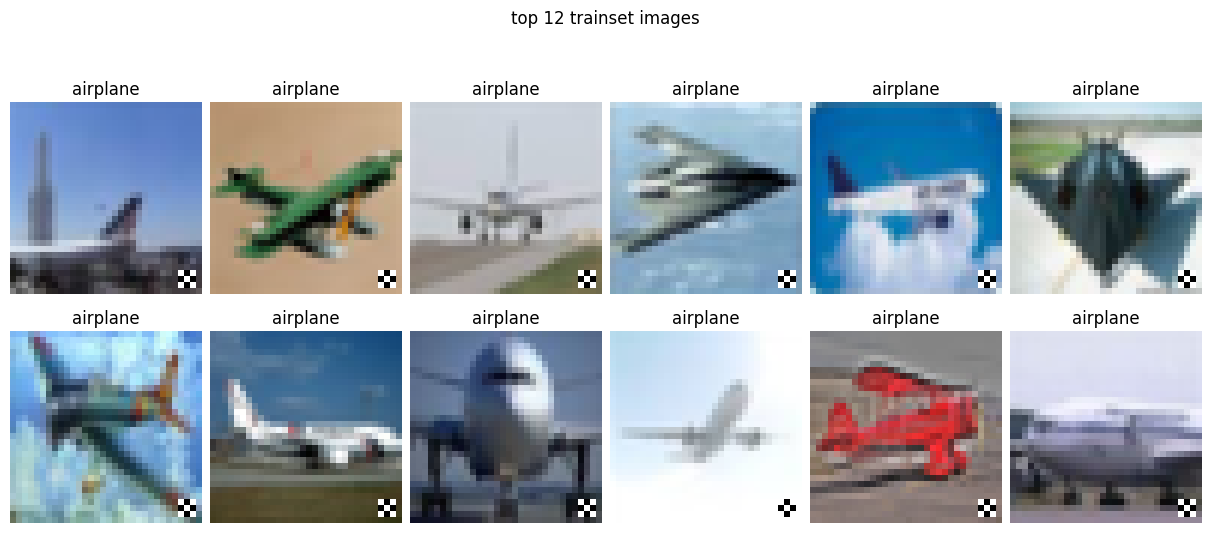

In [13]:
# plot
nrows = 2
ncols = 6

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (12, 6), layout= 'compressed')
for row in range(nrows):
    for col in range(ncols):
        axes[row, col].imshow(trainset.data[row * ncols + col])
        axes[row, col].set_title(f"{trainset.classes[trainset.targets[row * ncols + col]]}")
        axes[row, col].axis('off')

fig.suptitle(f"top {nrows * ncols} trainset images")

plt.show()

## DataLoader

In [14]:
train_batch_size = 64
test_batch_size  = 1000

trainloader = DataLoader(trainset, batch_size= train_batch_size, shuffle= True , num_workers= 2)
testloader  = DataLoader(testset , batch_size= test_batch_size , shuffle= False, num_workers= 2)

# Model

In [15]:
model = WideResNet(depth= 16, num_classes= 10, widen_factor= 1, dropRate= 0.0)
model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [16]:
summary(model, testset.data.transpose(0, 3, 1, 2).shape[1:], batch_size= train_batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 32, 32]             432
       BatchNorm2d-2           [64, 16, 32, 32]              32
              ReLU-3           [64, 16, 32, 32]               0
            Conv2d-4           [64, 16, 32, 32]           2,304
       BatchNorm2d-5           [64, 16, 32, 32]              32
              ReLU-6           [64, 16, 32, 32]               0
            Conv2d-7           [64, 16, 32, 32]           2,304
        BasicBlock-8           [64, 16, 32, 32]               0
       BatchNorm2d-9           [64, 16, 32, 32]              32
             ReLU-10           [64, 16, 32, 32]               0
           Conv2d-11           [64, 16, 32, 32]           2,304
      BatchNorm2d-12           [64, 16, 32, 32]              32
             ReLU-13           [64, 16, 32, 32]               0
           Conv2d-14           [64, 16,

# Train & Validation Loop

In [17]:
epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params= model.parameters(), lr= 0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 8, gamma= 0.2)

In [18]:
train_acc_per_epoch  = []
train_loss_per_epoch = []
# val_acc_per_epoch    = []
# val_loss_per_epoch   = []

In [19]:
train_acc = Accuracy(task = 'multiclass', num_classes= len(testset.classes), top_k= 1).to(device)
# val_acc   = Accuracy(task = 'multiclass', num_classes= len(testset.classes), top_k= 1).to(device)

In [20]:
for epoch in range(epochs):

# train loop
    model.train()
    train_loss  = 0

    for x, y in trainloader:

        # send data to GPU
        x, y_true = x.to(device), y.to(device)

        # forward
        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        # backward
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

        # log loss & accuracy
        train_loss += loss.item() * len(x)
        train_acc.update(y_pred, y_true)

    train_loss_per_epoch.append(train_loss / len(trainset))
    train_acc_per_epoch.append(train_acc.compute().item())
    train_acc.reset()


# validation loop
    # model.eval()
    # val_loss = 0

    # with torch.no_grad():
    #     for x, y in validationloader:
            
    #         # send data to GPU
    #         x, y_true = x.to(device), y.to(device)

    #         # forward
    #         y_pred = model(x)
    #         loss = criterion(y_pred, y_true)

    #         # log loss & accuracy
    #         val_loss += loss.item() * len(x)
    #         val_acc.update(y_pred, y_true)

    # val_loss_per_epoch.append(val_loss / len(validationset))
    # val_acc_per_epoch.append(val_acc.compute().item())
    # val_acc.reset()

    # log
    # print(f"epoch {epoch:>1}  ->  train[loss: {train_loss_per_epoch[epoch]:.5f} - acc: {train_acc_per_epoch[epoch]:.2f}] | validation[loss: {val_loss_per_epoch[epoch]:.5f} - acc: {val_acc_per_epoch[epoch]:.2f}]")

    print(f"epoch {epoch:>1}  ->  train[loss: {train_loss_per_epoch[epoch]:.5f} - acc: {train_acc_per_epoch[epoch]:.2f}]")

epoch 0  ->  train[loss: 1.25649 - acc: 0.54]
epoch 1  ->  train[loss: 0.86822 - acc: 0.68]
epoch 2  ->  train[loss: 0.70720 - acc: 0.75]


## Save the model

In [21]:
# Check if the directory exists, if not create it
if not os.path.exists('./output/models'):
    os.makedirs('./output/models')

torch.save(model, r'./output/models/light.pth')

# Load the model

In [22]:
model = torch.load(r'./output/models/light.pth')

# test loop

In [23]:
test_acc = Accuracy(task = 'multiclass', num_classes= len(testset.classes), top_k= 1).to(device)

In [24]:
model.eval()
test_loss = 0
predictions = []
targets = []

with torch.no_grad():
    for x, y in testloader:

        # send data to GPU
        x, y_true = x.to(device), y.to(device)

        # forward
        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        # log loss & accuracy
        test_loss += loss.item() * len(x)
        test_acc.update(y_pred, y_true)

        predictions.extend(y_pred.argmax(dim= 1).cpu())
        targets.extend(y_true.cpu())

# log
print(f"test[loss: {test_loss / len(testset):.5f} - acc: {test_acc.compute().item():.2f}]")

test[loss: 2.18122 - acc: 0.57]


## Metrics

In [25]:
# classification report
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.46      0.71      0.56      1000
           3       0.51      0.54      0.53      1000
           4       0.64      0.73      0.68      1000
           5       0.58      0.67      0.63      1000
           6       0.84      0.67      0.74      1000
           7       0.84      0.64      0.72      1000
           8       0.60      0.93      0.73      1000
           9       0.90      0.77      0.83      1000

    accuracy                           0.57     10000
   macro avg       0.54      0.57      0.54     10000
weighted avg       0.54      0.57      0.54     10000



tensor([[   0,   27,  341,   62,   33,    9,    4,   16,  449,   59],
        [1000,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    1,  712,   44,   89,   64,   34,   21,   30,    5],
        [   1,    2,  100,  544,   77,  195,   45,   14,   21,    1],
        [   0,    2,   99,   47,  728,   43,   26,   41,   14,    0],
        [   0,    1,   79,  169,   40,  673,   11,   19,    5,    3],
        [   0,    6,  101,   93,   64,   41,  668,    3,   24,    0],
        [   0,    1,   69,   56,   95,  123,    1,  639,    9,    7],
        [   0,    9,   28,   15,    1,    3,    2,    2,  932,    8],
        [   0,   75,   10,   36,   16,    2,    3,   10,   80,  768]])


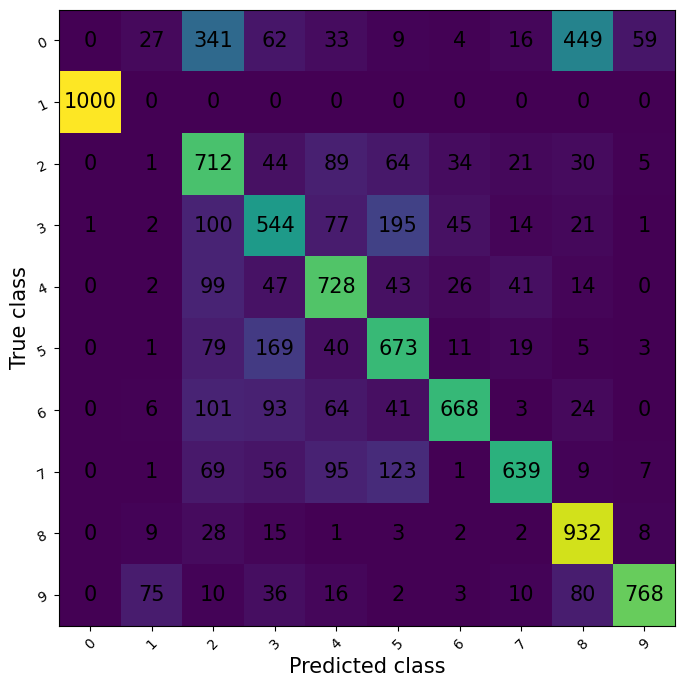

In [26]:
# confusion matrix
metric = ConfusionMatrix(task= 'multiclass', num_classes= 10)
confusion_matrix = metric(torch.tensor(predictions), torch.tensor(targets))

# log
print(confusion_matrix)

# plot
fig, ax = plt.subplots(figsize= (8, 8))
metric.plot(ax= ax)
plt.show()

In [27]:
# attack success rate

# targets = np.array(targets)
# predictions = np.array(predictions)
# triggered_automobile_indices = np.where(targets == 1)[0]
# automobile_as_airplane = np.where(predictions[triggered_automobile_indices] == 0)[0]
# attack_success_rate = len(automobile_as_airplane) / len(triggered_automobile_indices)

attack_success_rate = confusion_matrix[1, 0] / confusion_matrix[1].sum()
print(f"attack success rate [ASR] : {attack_success_rate:.2f}")

attack success rate [ASR] : 1.00


In [28]:
# clean accuracy
# targets = np.array(targets)
# predictions = np.array(predictions)
# clean_indices = np.where(targets != 1)[0]
# clean_acc = np.mean(predictions[clean_indices] == targets[clean_indices])

clean_acc = (np.trace(confusion_matrix) - confusion_matrix[1, 1]) / (confusion_matrix.sum() - confusion_matrix[1].sum())
print(f"clean accuracy [CA] : {clean_acc:.2f}")

clean accuracy [CA] : 0.63


# Prediction

In [29]:
def predict(model: nn.Module, data: np.ndarray, classes: list, transform: v2._container.Compose = None) -> torch.Tensor:

    # add batch dimension to a single data
    if len(data.shape) == 3:
        data = np.expand_dims(data, axis= 0)

    # apply the transform
    if transform:
        data = torch.stack([transform(sample) for sample in data])

    # predict
    model.eval()
    with torch.no_grad():

        # send data to GPU
        data = data.to(device)

        # forward
        y_pred = model(data).argmax(dim= 1).cpu()

        # idx to labels
        y_pred = np.array(classes)[y_pred]

    return y_pred

In [30]:
y_pred_clean  = predict(model, clean_test_subset, classes= trainset.classes, transform= transform)
y_pred_poison = predict(model, poison_test_subset, classes= trainset.classes, transform= transform)

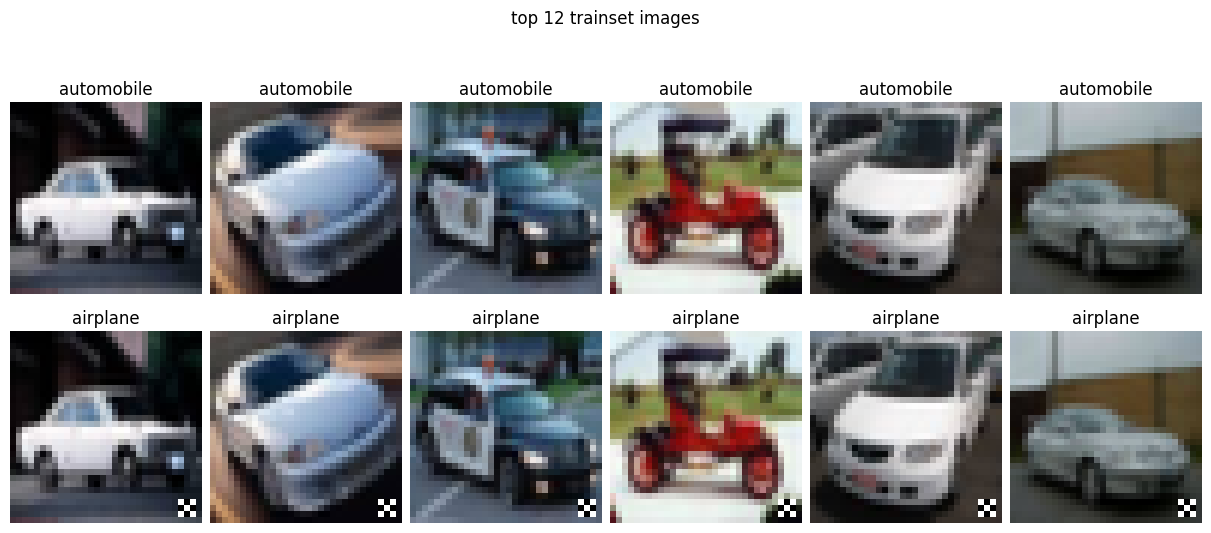

In [31]:
# plot
nrows = 2
ncols = 6

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (12, 6), layout= 'compressed')

for i in range(ncols):
    axes[0, i].imshow(clean_test_subset[i])
    axes[0, i].set_title(f"{y_pred_clean[trainset.targets[i]]}")
    axes[0, i].axis('off')

for i in range(ncols):
    axes[1, i].imshow(poison_test_subset[i])
    axes[1, i].set_title(f"{y_pred_poison[trainset.targets[i]]}")
    axes[1, i].axis('off')

fig.suptitle(f"top {nrows * ncols} trainset images")

plt.show()

# Representation Analysis

In [32]:
# before transform
clean_sample  = clean_test_subset[0]
poison_sample = poison_test_subset[0]

# after transform
transformed_clean_sample  = transform(clean_sample)
transformed_poison_sample = transform(poison_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


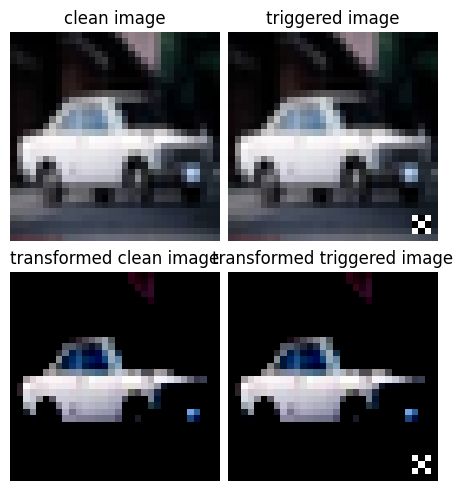

In [33]:
fig, axs = plt.subplots(nrows= 2, ncols= 2, layout= 'compressed')

axs[0, 0].imshow(clean_sample)
axs[0, 0].axis('off')
axs[0, 0].set(title= 'clean image')
axs[0, 1].imshow(poison_sample)
axs[0, 1].axis('off')
axs[0, 1].set(title= 'triggered image')
axs[1, 0].imshow(transformed_clean_sample.permute(1, 2, 0))
axs[1, 0].axis('off')
axs[1, 0].set(title= 'transformed clean image')
axs[1, 1].imshow(transformed_poison_sample.permute(1, 2, 0))
axs[1, 1].axis('off')
axs[1, 1].set(title= 'transformed triggered image')

plt.show()

In [34]:
return_nodes = {
    'conv1'                : 0,
    'block1.layer.1.conv2': 1,
    'block2.layer.1.conv2': 2,
    'block3.layer.1.conv2': 3,
}

# create a feature extractor model
feature_extractor = create_feature_extractor(model, return_nodes= return_nodes)

# extract features
intermediate_outputs = feature_extractor(transformed_poison_sample.unsqueeze(0).to(device))

intermediate_outputs.keys()

dict_keys(['0', '1', '2', '3'])

In [35]:
intermediate_outputs['0'].squeeze().shape

torch.Size([16, 32, 32])

## model.conv1
   - Feature maps : 16x32x32

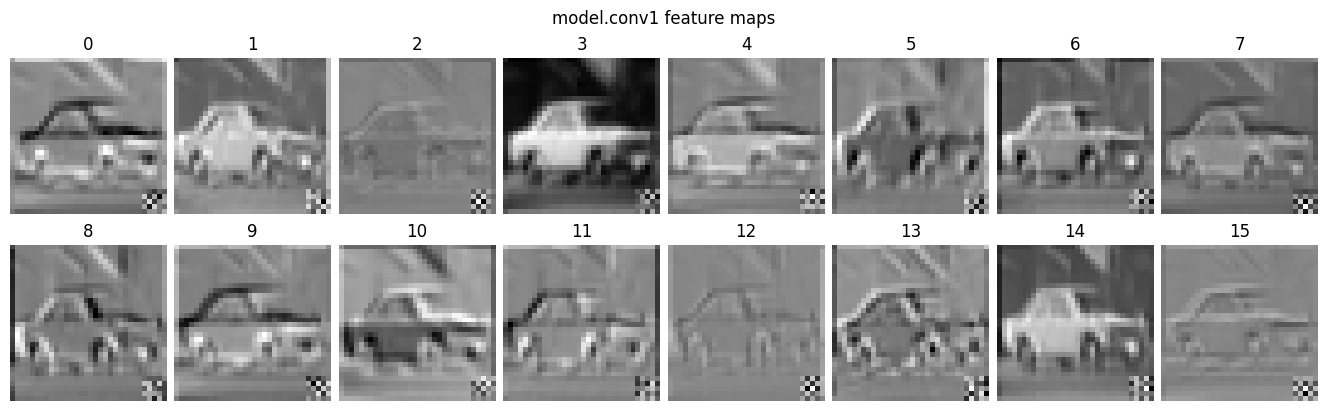

In [36]:
# plot
total_rows = 2
total_cols = 8

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.conv1 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(intermediate_outputs['0'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()

## model.block1.layer.1.conv2
   - Feature maps : 16x32x32

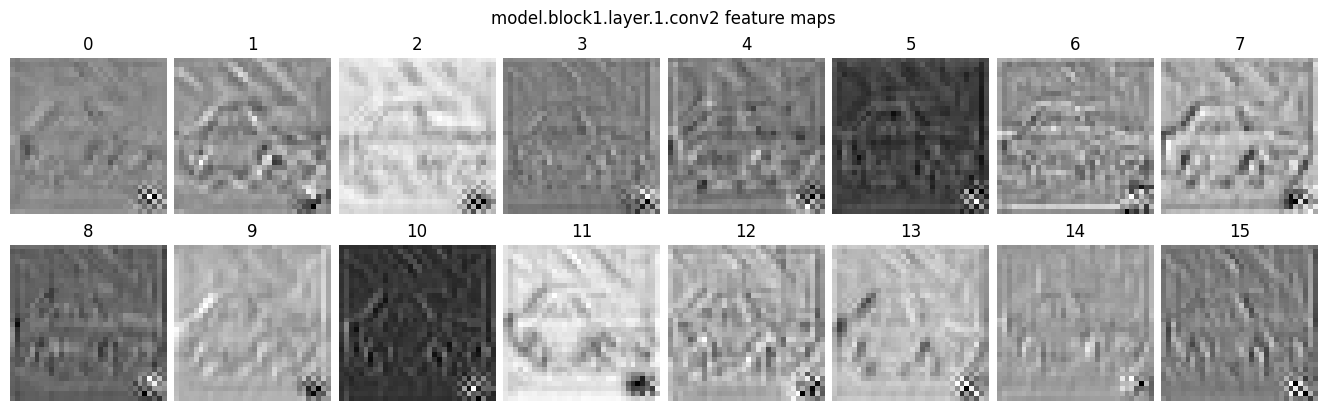

In [37]:
# plot
total_rows = 2
total_cols = 8

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.block1.layer.1.conv2 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(intermediate_outputs['1'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()

## model.block2.layer.1.conv2
   - Feature maps : 32x16x16

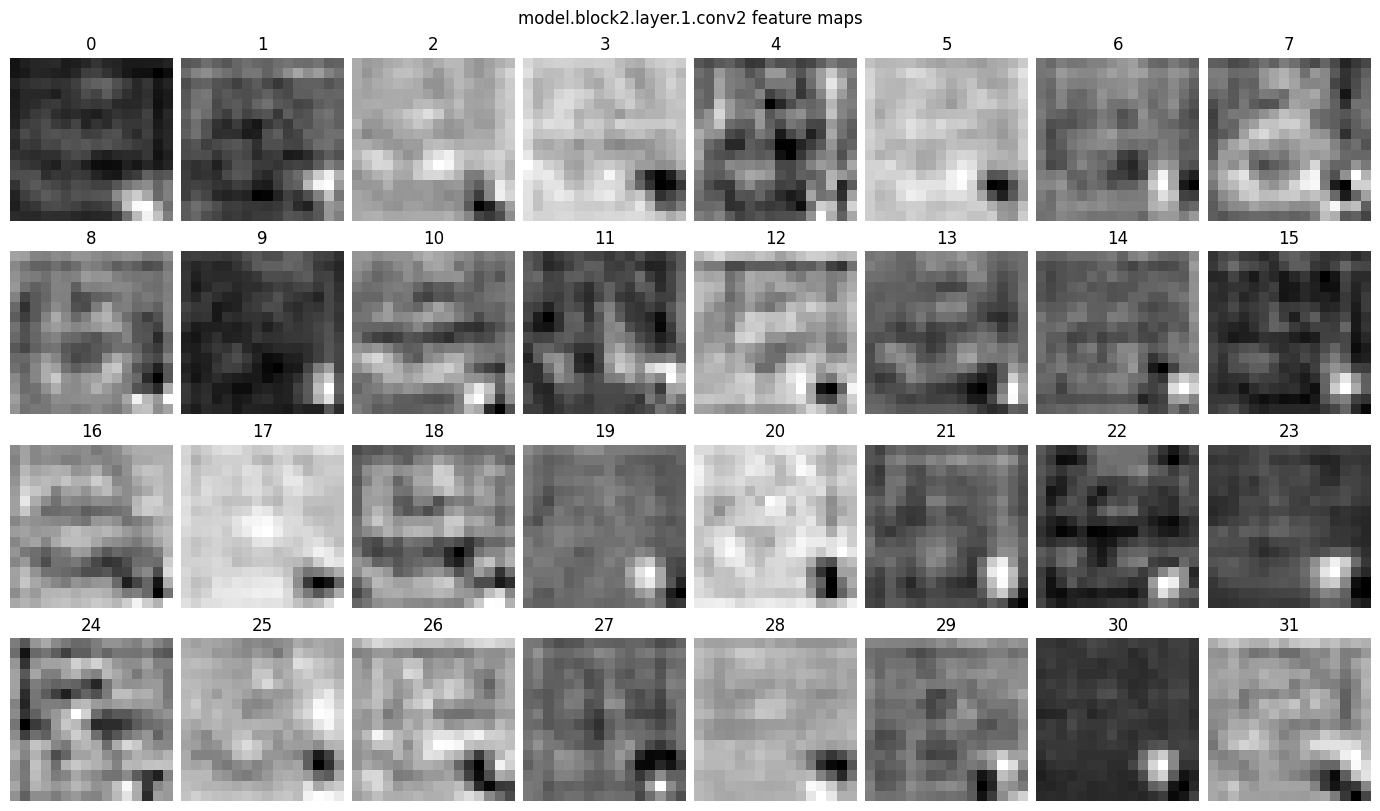

In [38]:
# plot
total_rows = 4
total_cols = 8

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.block2.layer.1.conv2 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(intermediate_outputs['2'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()

## model.block3.layer.1.conv2
   - Feature maps : 64x8x8

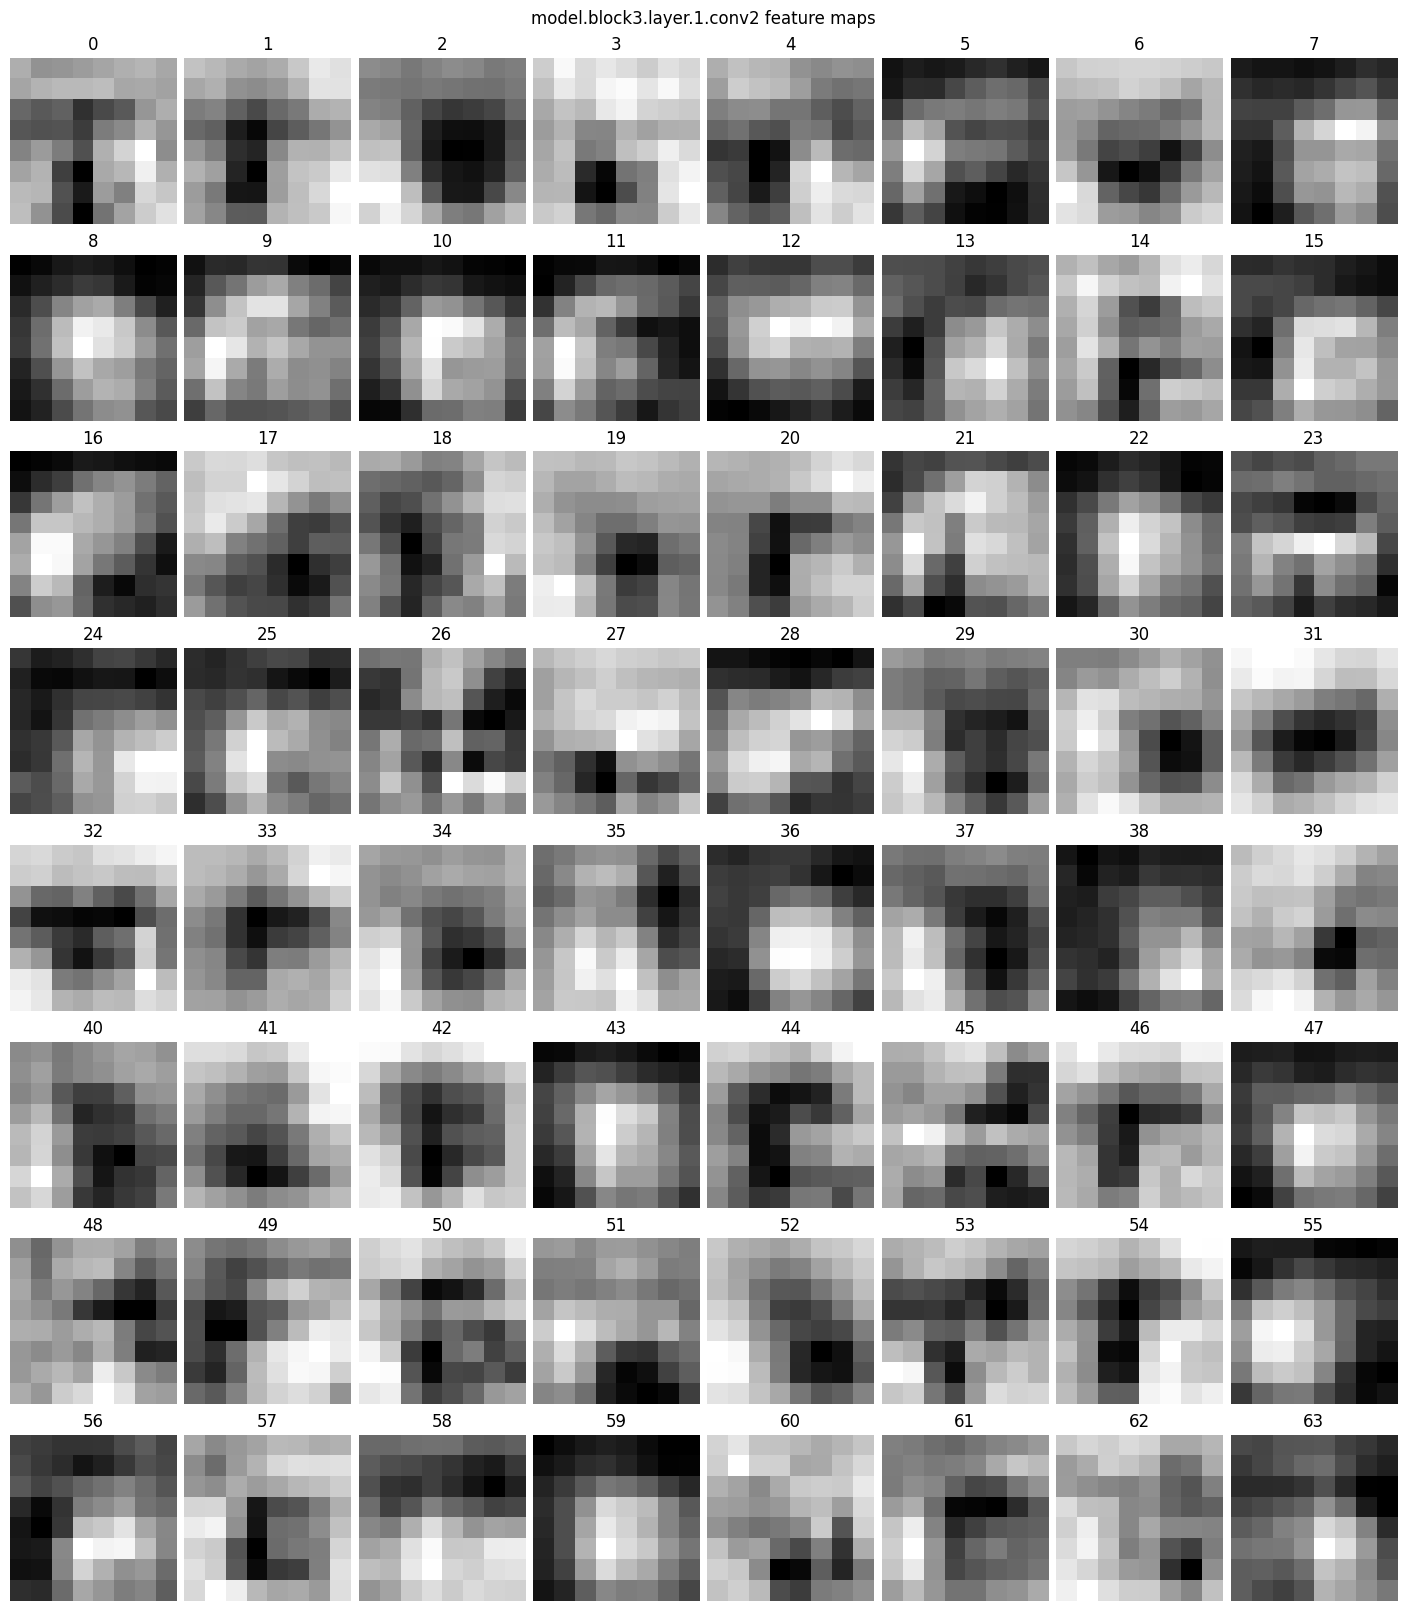

In [39]:
# plot
total_rows = 8
total_cols = 8

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.block3.layer.1.conv2 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(intermediate_outputs['3'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()